<a href="https://colab.research.google.com/github/nancyandrioli/aa-en-grafos/blob/main/tp_Challenge_lift_palabras_llamadas_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Viz Challenge

In [ ]:
import re
import pandas as pd
import copy
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
import random
import numpy as np
import nltk

from collections import Counter

from nltk import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

#Sólo una vez
#nltk.download('punkt')
#nltk.download('stopwords')

#sp_stopwords = stopwords.words('spanish')
#tokenizer = RegexpTokenizer('[a-z]{3,}')

###### Cargo los datasets

In [ ]:

#Subir data seeeets!!!!!

archivo_1='C:/Maestría Datos/Visualización/tp - Challenge/MC3/csv-1700-1830.csv'
archivo_2='C:/Maestría Datos/Visualización/tp - Challenge/MC3/csv-1831-2000.csv'
archivo_3='C:/Maestría Datos/Visualización/tp - Challenge/MC3/csv-2001-2131.csv'

df_archivo_1 = pd.read_csv(archivo_1)
df_archivo_2 = pd.read_csv(archivo_2)
df_archivo_3 = pd.read_csv(archivo_3)

df_total=pd.concat([df_archivo_1,df_archivo_2,df_archivo_3])
df_total.rename(columns={'date(yyyyMMddHHmmss)': 'date_time'}, inplace=True)

#### Genero features nuevos

In [ ]:
df_total.date_time = df_total.date_time.astype('str')
df_total.message = df_total.message.astype('str')

df_total['date'] = df_total.date_time.str.slice(0, 8)
df_total['time'] = df_total.date_time.str.slice(8, 14)
df_total.time = df_total.time.astype('int')

df_total['time_hour'] = df_total.date_time.str.slice(8, 10)
df_total['time_min']  = df_total.date_time.str.slice(10, 12)
df_total['time_seg']  = df_total.date_time.str.slice(12, 14)

In [ ]:
stop_words=stopwords.words("english")
stop_words.append('hi')
stop_words.append('!')
stop_words.append("n't")
stop_words.append("do")
#stop_words.append("#")
#stop_words.append("@")
stop_words.append("?")
stop_words.append('"')
stop_words.append('.')
stop_words.append('rt')
stop_words.append(',')
stop_words.append("'s")
stop_words.append("'")
stop_words.append("''")
stop_words.append('-')
stop_words.append(':')
stop_words.append('...')


#print(stop_words)

In [ ]:
df_total.head()

,type,date_time,author,message,latitude,longitude,location,date,time,time_hour,time_min,time_seg
0,mbdata,20140123170000,POK,Follow us @POK-Kronos,NaN,NaN,NaN,20140123,170000,17,00,00
1,mbdata,20140123170000,maha_Homeland,Don't miss a moment! Follow our live coverage of the POK Rally in the Park!,NaN,NaN,NaN,20140123,170000,17,00,00
2,mbdata,20140123170000,Viktor-E,Come join us in the Park! Music tonight at Abila City Park!,NaN,NaN,NaN,20140123,170000,17,00,00
3,mbdata,20140123170000,KronosStar,POK rally to start in Abila City Park. POK leader Sylvia Marek to open with a speech.� #KronosStar,NaN,NaN,NaN,20140123,170000,17,00,00
4,mbdata,20140123170000,AbilaPost,POK rally set to take place in Abila City Park - POK leader Sylvia Marek has begun with opening remarks #AbilaPost,NaN,NaN,NaN,20140123,170000,17,00,00


#### Separo microblogs de llamadas

In [ ]:
#Micro blogs
df_mbdata_orig=df_total[df_total.type=='mbdata']

#LLamadas
df_ccdata_orig=df_total[df_total.type=='ccdata']

#Ver de standarizar mejor
df_ccdata['message'] = df_ccdata_orig['message'].str.replace(' - ','-').copy()

c:\python374\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


En función de análisis previos limpio algunos mensajes

Elimino los mensajes con el texto "INCOMPLETE CALL FOR POLICE"

In [ ]:
#INCOMPLETE CALL FOR POLICE
df_ccdata=df_ccdata[df_ccdata.message!="INCOMPLETE CALL FOR POLICE"]

In [ ]:
df_ccdata['message_tokenized'] = df_ccdata.apply(lambda row: nltk.word_tokenize(row['message'].lower()), axis=1)
df_ccdata['message_tokenized'] = df_ccdata['message_tokenized'].apply(lambda words: [word for word in words if word not in stop_words])

#tokenized_word=word_tokenize(str(df_mbdata.message[1]))
#tokenized_word

##### Calculo el porcentaje de mensajes de cada tipo que hay en el dataset de llamadas de emergencia

In [ ]:
df_ccdata_agrupado=df_ccdata.copy()
df_ccdata_agrupado.rename(columns={'type': 'porcent'}, inplace=True)
df_ccdata_agrupado.rename(columns={'date': 'frec'}, inplace=True)

df_ccdata_agrupado = df_ccdata_agrupado.groupby(["message"], as_index=False).count().copy()

#Ordeno por porcenaje de veces que aparece
df_ccdata_agrupado.sort_values(by=['porcent'], inplace=True, ascending=False)

df_ccdata_agrupado.porcent=df_ccdata_agrupado.porcent/df_ccdata.shape[0]*100
df_ccdata_porcentajes_total=df_ccdata_agrupado[["message","frec","porcent"]].copy()
#df_ccdata_porcentajes_total.head(50)

#### Calculo el  porcentaje de cada tipo de mensaje para cada rango horario

In [ ]:
df_ccdata_mensaje_horario=df_ccdata.copy()
df_ccdata_mensaje_horario.rename(columns={'type': 'frec'}, inplace=True)

df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=170000) & (df_ccdata_mensaje_horario.time<180000),'rango_horario']='17-18'
df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=180000) & (df_ccdata_mensaje_horario.time<190000),'rango_horario']='18-19'
df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=190000) & (df_ccdata_mensaje_horario.time<200000),'rango_horario']='19-20'
df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=200000) ,'rango_horario']='20-2130'

#df_ccdata_horario.head()

df_ccdata_mensaje_horario_agrupado = df_ccdata_mensaje_horario.groupby(["message","rango_horario"], as_index=False).count().copy()
df_ccdata_mensaje_horario_agrupado.sort_values(by=['frec','rango_horario'], inplace=True, ascending=False)

df_ccdata_mensaje_horario_agrupado=df_ccdata_mensaje_horario_agrupado[["message","frec","rango_horario"]]
df_ccdata_mensaje_horario_agrupado["frec"]=df_ccdata_mensaje_horario_agrupado["frec"].astype(np.float64)
#df_ccdata_mensaje_horario_agrupado.head(30)

In [ ]:
df_ccdata_rango_horario_agrupado = df_ccdata_mensaje_horario.groupby(["rango_horario"], as_index=False).count().copy()
df_ccdata_rango_horario_agrupado=df_ccdata_rango_horario_agrupado[['rango_horario','frec']]

#df_ccdata_rango_horario_agrupado.head()

In [ ]:
df_ccdata_mensaje_horario_agrupado_copia=df_ccdata_mensaje_horario_agrupado.copy()

# Es muy ineficiente modificar!!!!!!!
df_ccdata_mensaje_horario_agrupado_copia['porcent']=0.0

for i in range(0,len(df_ccdata_mensaje_horario_agrupado_copia)):
    df_ccdata_mensaje_horario_agrupado_copia.loc[i,'porcent']=df_ccdata_mensaje_horario_agrupado_copia.loc[i,'frec']/float(df_ccdata_rango_horario_agrupado.loc[df_ccdata_rango_horario_agrupado.rango_horario==df_ccdata_mensaje_horario_agrupado_copia.loc[i,'rango_horario'],'frec'])*100
    

#### Calculo el lift de cada tipo de mensaje para cada rango horario

In [ ]:
df_ccdata_mensaje_horario_agrupado_lift=df_ccdata_mensaje_horario_agrupado_copia.copy()

cant_filas=df_ccdata_mensaje_horario_agrupado_lift.shape[0]
df_ccdata_mensaje_horario_agrupado_lift['lift']=0.0

for i in range(0,cant_filas):
    fila=df_ccdata_mensaje_horario_agrupado_lift.iloc[i]
    message=fila['message']
    
    porcent_mensaje_total=float(df_ccdata_porcentajes_total.loc[df_ccdata_porcentajes_total.message==df_ccdata_mensaje_horario_agrupado_lift.at[i,'message'],'porcent'])
    porcent_mensaje_horario=float(df_ccdata_mensaje_horario_agrupado_lift.iloc[i].porcent)
    
    df_ccdata_mensaje_horario_agrupado_lift.at[i,'lift']=float(df_ccdata_mensaje_horario_agrupado_lift.at[i,'porcent'])/float(df_ccdata_porcentajes_total.loc[df_ccdata_porcentajes_total.message==df_ccdata_mensaje_horario_agrupado_lift.at[i,'message'],'porcent'])
    
#    if(df_ccdata_mensaje_horario_agrupado_lift.at[i,'message']== 'PARK CHECK'):     
    '''
    print(df_ccdata_mensaje_horario_agrupado_lift.at[i,'message'])
    print(df_ccdata_mensaje_horario_agrupado_lift.at[i,'rango_horario'])
    print("porcent: "+str(df_ccdata_mensaje_horario_agrupado_lift.at[i,'porcent']))
    print("frec: "+str(df_ccdata_mensaje_horario_agrupado_lift.at[i,'frec']))
    print("porcent total: "+str(float(porcent_mensaje_total)))
    print("lift: "+str(df_ccdata_mensaje_horario_agrupado_lift.at[i,'lift']))
    print('---------------------------------------')
    '''
    
    '''
    print(message)
    print("total "+str(float(frac_mensaje_total)))
    print("frac horario"+str(df_ccdata_horario_agrupado_copia_copia.iloc[i].porcent))
    print("frac aux: "+str(frac))
    df_ccdata_horario_agrupado_copia_copia.at[i,'porcent']=frac
    print("lift: "+str(df_ccdata_horario_agrupado_copia_copia.iloc[i].porcent))
    print('----------------------')
    '''

In [ ]:
df_ccdata_mensaje_horario_agrupado_lift.sort_values(by=['lift','frec'], inplace=True, ascending=False)

#df_ccdata_mensaje_horario_agrupado_lift.head(50)
#df_ccdata_horario_agrupado_copia_copia.sort_values(by=['type'], inplace=True, ascending=False)
#df_ccdata_horario_agrupado_copia_copia.head(30)
#SUSPICIOUS OCCUPIED VEHICLE-BLACK VAN
#df_ccdata_mensaje_horario_agrupado_lift[df_ccdata_mensaje_horario_agrupado_lift['message']=="SUSPICIOUS OCCUPIED VEHICLE-BLACK VAN"]

#df_ccdata_mensaje_horario_agrupado_lift[df_ccdata_mensaje_horario_agrupado_lift['frec']>2].head(50)
#df_ccdata_mensaje_horario_agrupado_lift.head(100)

### Distancia coseno

In [ ]:
message_unicos = df_ccdata['message'].unique().astype('U')

In [ ]:
def ngrams_analyzer(string):
    string = re.sub(r'[,-./]', r'', string)
    ngrams = zip(*[string[i:] for i in range(3)])  #anagrama de longitud 5
    return [''.join(ngram) for ngram in ngrams]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#vectorizer = TfidfVectorizer(analyzer=ngrams_analyzer) #No lo voy a usar, dejo el default
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(message_unicos)

#pd.DataFrame(tfidf_matrix).head()

In [ ]:
words = vectorizer.get_feature_names()
len(words)
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
queryTFIDF = TfidfVectorizer().fit(words)

In [ ]:
#pd.DataFrame(similarity_matrix)

In [ ]:
pd.DataFrame(message_unicos)

,0
0,KEEP THE PEACE-CROWD CONTROL/ABILA CITY PARK
1,TRAFFIC STOP
2,PARK CHECK
3,DISTURBANCE-NOISE
4,ALARM-SECURE NO CRIME
5,MISDEMEANOR ASSAULT-IN PROGRESS
6,SUBJECT STOP
7,SUSPICIOUS SUBJECT/CIRCUMSTANCES-IN PROGRESS
8,BUSINESS CHECK
9,VEHICLE ACCIDENT-REPORT


In [ ]:
#Transformo similaridad en distancia
from sklearn.cluster import AgglomerativeClustering
distance_matrix=1-similarity_matrix

clustering = AgglomerativeClustering(
    distance_threshold=0.80, # this parameter needs to be tuned carefully
    affinity="precomputed", linkage="complete", n_clusters=None
  ).fit(distance_matrix)


mensajes_grupos=pd.DataFrame({"message":message_unicos,"grupo":clustering.labels_})

In [ ]:
mensajes_grupos.sort_values(by=['grupo'], inplace=True, ascending=True)
mensajes_grupos.head(100)

,message,grupo
21,FELONY HIT & RUN-IN PROGRESS-WITH INJURY,0
30,FELONY ASSAULT/WEAPON-IN PROGRESS,0
26,RECKLESS/HAZARADOUS DRIVER-IN PROGRESS,0
5,MISDEMEANOR ASSAULT-IN PROGRESS,0
7,SUSPICIOUS SUBJECT/CIRCUMSTANCES-IN PROGRESS,0
39,NARCOTIC ACTIVITY-REPORT,1
13,POSSIBLE FIRE-REPORT,1
12,VANDALISM-REPORT,1
19,POLICE UNIT DISPATCHED-CROWD CONTROL,2
11,CROWD CONTROL-STREET CLOSURE,2


In [ ]:
df_ccdata_mensajes_grupos=df_ccdata.set_index('message').join(mensajes_grupos.set_index('message'))
df_ccdata_mensajes_grupos=df_ccdata_mensajes_grupos.reset_index()
df_ccdata_mensajes_grupos.head()

,message,type,date_time,author,latitude,longitude,location,date,time,time_hour,time_min,time_seg,message_tokenized,grupo
0,ALARM-SECURE NO CRIME,ccdata,20140123171153,NaN,NaN,NaN,3815 N. Blant St,20140123,171153,17,11,53,"[alarm-secure, crime]",16
1,ALARM-SECURE NO CRIME,ccdata,20140123172251,NaN,NaN,NaN,4357 N. Blant St,20140123,172251,17,22,51,"[alarm-secure, crime]",16
2,ALARM-SECURE NO CRIME,ccdata,20140123173200,NaN,NaN,NaN,3234 N. Avionos St,20140123,173200,17,32,00,"[alarm-secure, crime]",16
3,ALARM-SECURE NO CRIME,ccdata,20140123174611,NaN,NaN,NaN,2411 N. Averof St,20140123,174611,17,46,11,"[alarm-secure, crime]",16
4,ALARM-SECURE NO CRIME,ccdata,20140123180401,NaN,NaN,NaN,3247 N. Mikonou St,20140123,180401,18,04,01,"[alarm-secure, crime]",16


In [ ]:
df_ccdata_agrupado=df_ccdata_mensajes_grupos.copy()
df_ccdata_agrupado.rename(columns={'type': 'porcent'}, inplace=True)
df_ccdata_agrupado.rename(columns={'date': 'frec'}, inplace=True)

df_ccdata_agrupado = df_ccdata_agrupado.groupby(["grupo"], as_index=False).count().copy()

#Ordeno por porcenaje de veces que aparece
df_ccdata_agrupado.sort_values(by=['porcent'], inplace=True, ascending=False)

df_ccdata_agrupado.porcent=df_ccdata_agrupado.porcent/df_ccdata.shape[0]*100
df_ccdata_porcentajes_total=df_ccdata_agrupado[["grupo","frec","porcent"]].copy()
#df_ccdata_porcentajes_total.head(50)

In [ ]:
df_ccdata_mensaje_horario=df_ccdata_mensajes_grupos.copy()
df_ccdata_mensaje_horario.rename(columns={'type': 'frec'}, inplace=True)

df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=170000) & (df_ccdata_mensaje_horario.time<180000),'rango_horario']='17-18'
df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=180000) & (df_ccdata_mensaje_horario.time<190000),'rango_horario']='18-19'
df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=190000) & (df_ccdata_mensaje_horario.time<200000),'rango_horario']='19-20'
df_ccdata_mensaje_horario.loc[(df_ccdata_mensaje_horario.time>=200000) ,'rango_horario']='20-2130'

#df_ccdata_horario.head()

df_ccdata_mensaje_horario_agrupado = df_ccdata_mensaje_horario.groupby(["grupo","rango_horario"], as_index=False).count().copy()
df_ccdata_mensaje_horario_agrupado.sort_values(by=['frec','rango_horario'], inplace=True, ascending=False)

df_ccdata_mensaje_horario_agrupado=df_ccdata_mensaje_horario_agrupado[["grupo","frec","rango_horario"]]
df_ccdata_mensaje_horario_agrupado["frec"]=df_ccdata_mensaje_horario_agrupado["frec"].astype(np.float64)
df_ccdata_mensaje_horario_agrupado.head(30)

,grupo,frec,rango_horario
28,12,15.0,18-19
27,12,13.0,17-18
30,12,12.0,20-2130
40,17,11.0,19-20
29,12,9.0,19-20
2,0,8.0,19-20
0,0,7.0,17-18
3,0,6.0,20-2130
14,6,6.0,17-18
1,0,5.0,18-19


In [ ]:
df_ccdata_rango_horario_agrupado = df_ccdata_mensaje_horario.groupby(["rango_horario"], as_index=False).count().copy()
df_ccdata_rango_horario_agrupado=df_ccdata_rango_horario_agrupado[['rango_horario','frec']]

df_ccdata_rango_horario_agrupado.head()

,rango_horario,frec
0,17-18,41
1,18-19,43
2,19-20,56
3,20-2130,36


In [ ]:
df_ccdata_mensaje_horario_agrupado_copia=df_ccdata_mensaje_horario_agrupado.copy()

# Es muy ineficiente modificar!!!!!!!

df_ccdata_mensaje_horario_agrupado_copia['porcent']=0.0

for i in range(0,len(df_ccdata_mensaje_horario_agrupado_copia)):
    df_ccdata_mensaje_horario_agrupado_copia.loc[i,'porcent']=df_ccdata_mensaje_horario_agrupado_copia.loc[i,'frec']/float(df_ccdata_rango_horario_agrupado.loc[df_ccdata_rango_horario_agrupado.rango_horario==df_ccdata_mensaje_horario_agrupado_copia.loc[i,'rango_horario'],'frec'])*100

    #print("cant mensajes: "+str((cant_mensajes_rango)))    
    #frac=(float(fila.frec)/float(cant_mensajes_rango))
    #df_ccdata_mensaje_horario_agrupado_copia.loc[i,'porcent']=frac    
    #print("campo ds:"+str(df_ccdata_mensaje_horario_agrupado_copia.loc[i].at['porcent'])) 
                                                                                                                      
#df_ccdata_mensaje_horario_agrupado_copia.sort_values(by=['frec'], inplace=True, ascending=False)
#df_ccdata_mensaje_horario_agrupado_soporte_grande=df_ccdata_mensaje_horario_agrupado_copia.loc[(df_ccdata_mensaje_horario_agrupado_copia.frec>1)]
#df_ccdata_mensaje_horario_agrupado_copia.head(100)

#df_ccdata_mensaje_horario_agrupado_copia[df_ccdata_mensaje_horario_agrupado_copia.message=='SUSPICIOUS OCCUPIED VEHICLE-BLACK VAN'].head(100)

In [ ]:
#cant_grupos=max(df_ccdata_mensaje_horario_agrupado_copia.grupo)
#df_ccdata_mensaje_horario_agrupado_copia.head(cant_grupos)

In [ ]:
df_ccdata_mensaje_horario_agrupado_lift=df_ccdata_mensaje_horario_agrupado_copia.copy()

cant_filas=df_ccdata_mensaje_horario_agrupado_lift.shape[0]
df_ccdata_mensaje_horario_agrupado_lift['lift']=0.0

for i in range(0,cant_filas):
    fila=df_ccdata_mensaje_horario_agrupado_lift.iloc[i]
    #message=fila['message']
    
    #porcent_mensaje_total=float(df_ccdata_porcentajes_total.loc[df_ccdata_porcentajes_total.message==df_ccdata_mensaje_horario_agrupado_lift.at[i,'message'],'porcent'])
    #porcent_mensaje_horario=float(df_ccdata_mensaje_horario_agrupado_lift.iloc[i].porcent)
    
    df_ccdata_mensaje_horario_agrupado_lift.at[i,'lift']=float(df_ccdata_mensaje_horario_agrupado_lift.at[i,'porcent'])/float(df_ccdata_porcentajes_total.loc[df_ccdata_porcentajes_total.grupo==df_ccdata_mensaje_horario_agrupado_lift.at[i,'grupo'],'porcent'])
    
#    if(df_ccdata_mensaje_horario_agrupado_lift.at[i,'message']== 'PARK CHECK'):     
    '''
    print(df_ccdata_mensaje_horario_agrupado_lift.at[i,'message'])
    print(df_ccdata_mensaje_horario_agrupado_lift.at[i,'rango_horario'])
    print("porcent: "+str(df_ccdata_mensaje_horario_agrupado_lift.at[i,'porcent']))
    print("frec: "+str(df_ccdata_mensaje_horario_agrupado_lift.at[i,'frec']))
    print("porcent total: "+str(float(porcent_mensaje_total)))
    print("lift: "+str(df_ccdata_mensaje_horario_agrupado_lift.at[i,'lift']))
    print('---------------------------------------')
    '''
    
    '''
    print(message)
    print("total "+str(float(frac_mensaje_total)))
    print("frac horario"+str(df_ccdata_horario_agrupado_copia_copia.iloc[i].porcent))
    print("frac aux: "+str(frac))
    df_ccdata_horario_agrupado_copia_copia.at[i,'porcent']=frac
    print("lift: "+str(df_ccdata_horario_agrupado_copia_copia.iloc[i].porcent))
    print('----------------------')
    '''

In [ ]:
df_ccdata_mensaje_horario_agrupado_lift_sorted=df_ccdata_mensaje_horario_agrupado_lift.sort_values('lift',ascending=False)
df_ccdata_mensaje_horario_agrupado_lift_sorted.head(100)

,grupo,frec,rango_horario,porcent,lift
18,7,2.0,20-2130,5.555556,4.888889
31,13,1.0,20-2130,2.777778,4.888889
26,11,2.0,20-2130,5.555556,3.259259
24,10,3.0,19-20,5.357143,3.142857
40,17,11.0,19-20,19.642857,3.142857
35,15,1.0,19-20,1.785714,3.142857
9,3,2.0,19-20,3.571429,3.142857
42,18,3.0,20-2130,8.333333,2.933333
7,2,2.0,17-18,4.878049,2.861789
10,4,3.0,18-19,6.976744,2.455814


In [ ]:
#df_ccdata_mensaje_horario=df_ccdata_mensaje_horario.reset_index()
#df_ccdata_mensaje_horario.head()

In [ ]:
#df_ccdata_mensaje_horario=df_ccdata_mensaje_horario.reset_index()
#df_ccdata_mensaje_horario.head()

In [ ]:

#df_ccdata_mensajes_grupos=df_ccdata_mensaje_horario.set_index(['message']).join(mensajes_grupos.set_index(['message']))
#df_ccdata_mensaje_horario=df_ccdata_mensaje_horario.reset_index()
#mensajes_grupos=mensajes_grupos.reset_index()
#df_ccdata_mensajes_grupos=df_ccdata_mensaje_horario.set_index(['message']).join(mensajes_grupos.set_index(['message']))


#fd_aux1=(df_ccdata_mensaje_horario[['message','rango_horario','time']]).copy()
#df_ccdata_mensajes_grupos_=(df_ccdata_mensajes_grupos.set_index(['grupo']).join(mensajes_grupos.set_index(['grupo'])))

df_ccdata_mensaje_horario.drop('frec', inplace=True, axis=1)

df_ccdata_mensajes_grupos_aux=df_ccdata_mensaje_horario_agrupado_lift.set_index(['grupo','rango_horario']).join(df_ccdata_mensaje_horario.set_index(['grupo','rango_horario']))
df_ccdata_mensajes_grupos_aux=df_ccdata_mensajes_grupos_aux.reset_index()
#df_ccdata_mensajes_grupos_aux.head(100)


(array([160000., 170000., 180000., 190000., 200000., 210000., 220000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

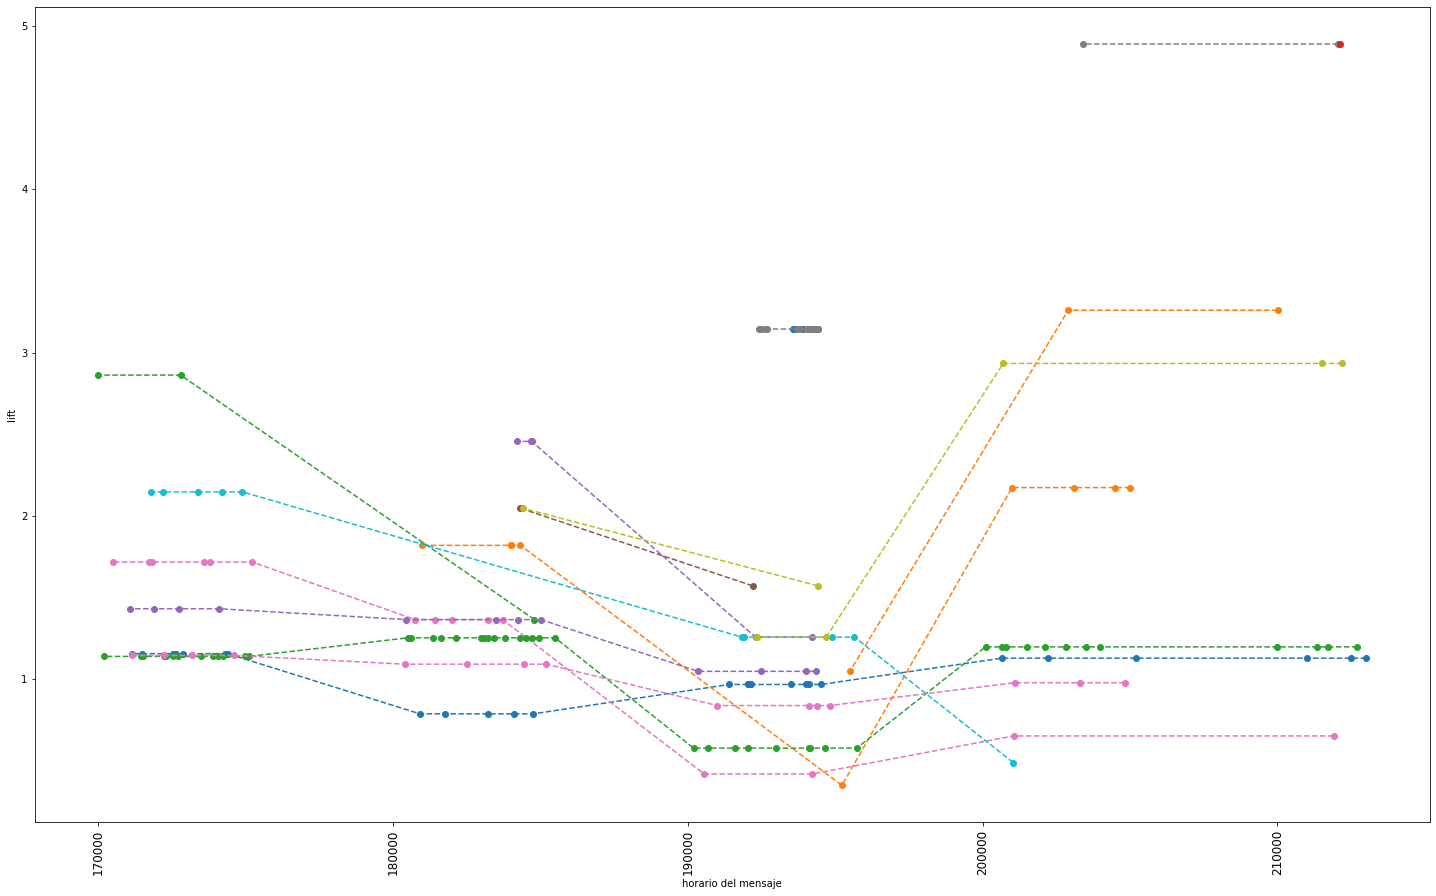

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap = plt.cm.get_cmap('Spectral')
#cmap=sns.color_palette("icefire")

cant_colores=max(df_ccdata_mensajes_grupos_aux.grupo)+1
cant=df_ccdata_mensajes_grupos_aux.shape[0]

#Linea punteada
df_ccdata_mensajes_grupos_aux_selected=df_ccdata_mensajes_grupos_aux[df_ccdata_mensajes_grupos_aux.frec>=1]    
df_ccdata_mensajes_grupos_aux_sorted=df_ccdata_mensajes_grupos_aux_selected.sort_values(['grupo','date_time'],ascending=False)


grupos=df_ccdata_mensajes_grupos_aux.grupo.unique()

plt.figure(figsize=(25,15))
for grupo in grupos:
#if 1==1:
    #grupo=0
    color=cmap((grupo)/cant_colores)
    df_ccdata_mensajes_grupos_aux_filtro=df_ccdata_mensajes_grupos_aux_sorted[df_ccdata_mensajes_grupos_aux_sorted.grupo==grupo]    
    
    plt.plot(df_ccdata_mensajes_grupos_aux_filtro.time,df_ccdata_mensajes_grupos_aux_filtro.lift,'o--')

plt.ylabel("lift")
plt.xlabel("horario del mensaje")
plt.xticks(rotation=90,fontsize=12)
#plt.legend(fontsize=12)
#plt.legend(fontsize=12)    

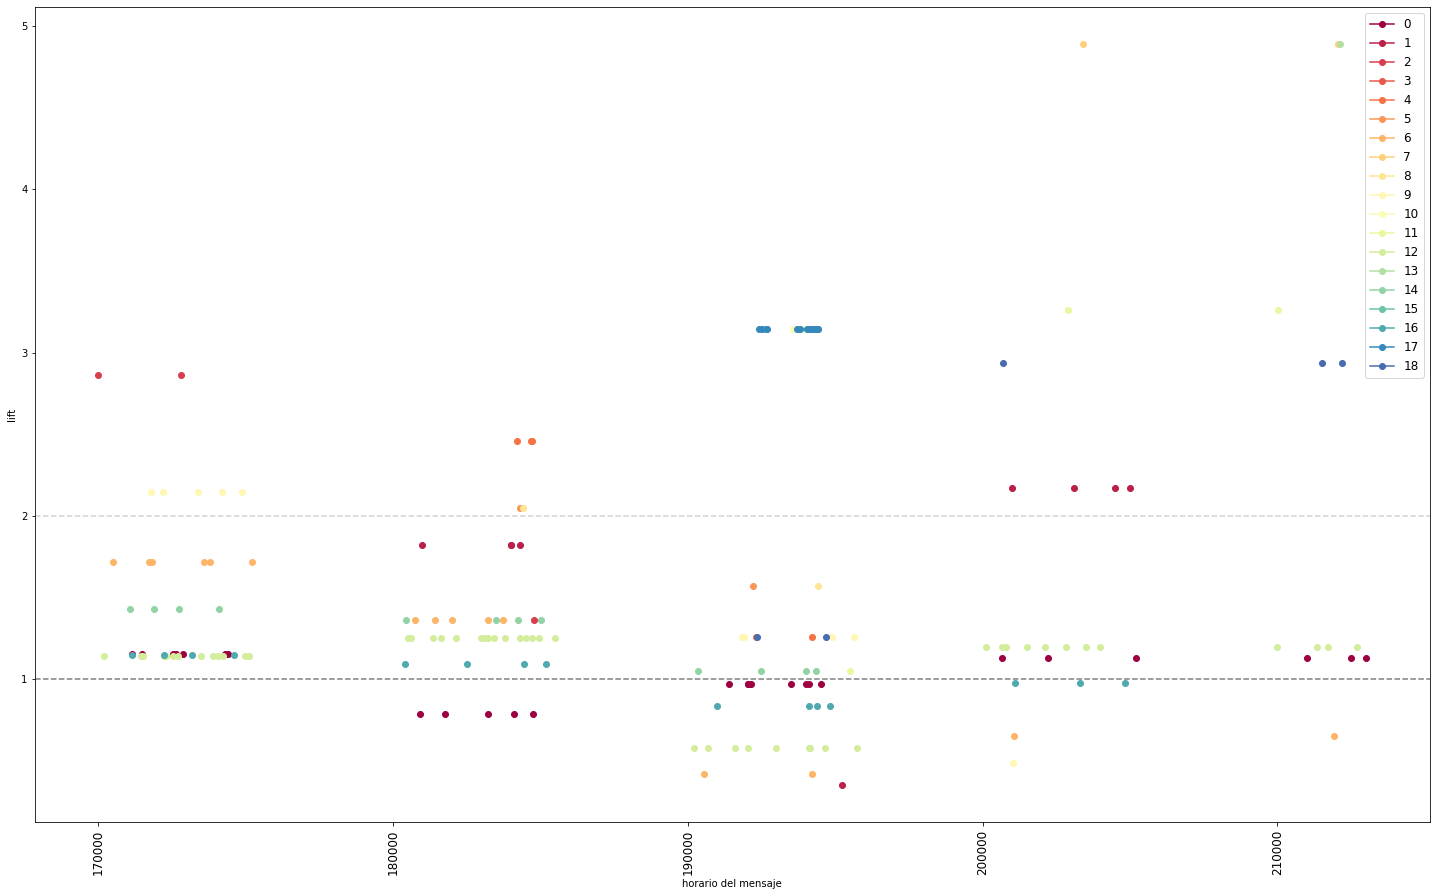

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap = plt.cm.get_cmap('Spectral')
#cmap=sns.color_palette("icefire")

cant_colores=max(df_ccdata_mensajes_grupos_aux.grupo)+1
cant=df_ccdata_mensajes_grupos_aux.shape[0]

#Linea punteada
df_ccdata_mensajes_grupos_aux_sorted=df_ccdata_mensajes_grupos_aux.sort_values('grupo',ascending=False)




plt.figure(figsize=(25,15))
label_ant=""
for i in range(0,cant):
    fila=df_ccdata_mensajes_grupos_aux.iloc[i]
    
    if (label_ant!=fila.grupo):
        label_ant=fila.grupo
        label=fila.grupo
    else:
        label=""
        
    plt.plot(fila.time,fila.lift,'o-',color=cmap((fila.grupo)/cant_colores),label=str(label))

plt.axhline(y=1, color='grey', linestyle='--')
plt.axhline(y=2, color='lightgrey', linestyle='--')
plt.ylabel("lift")
plt.xlabel("horario del mensaje")
plt.xticks(rotation=90,fontsize=12)
plt.legend(fontsize=12)
#x0, y0, width, height = 0.5, -0.2, -0.1, 0.4
#plt.legend(ncol=cant_colores,fontsize=12)
plt.legend(fontsize=12)